### LLM Inference Benchmarking with vLLM

#### Overview
This notebook demonstrates how to benchmark Large Language Model (LLM) inference using vLLM, a high-performance inference engine. We use a small model (OPT-125M) to understand the basics of throughput measurement and the impact of different parameters on inference speed.

#### Environment Setup

First, install the required packages:

In [ ]:
# install via pip
!pip -q install --upgrade pip
!pip -q install "vllm>=0.5.4" transformers accelerate pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Import the necessary libraries:

In [ ]:
# Import necessary libraries
import os
import time
import math
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import vllm

# Optional: nicer plotting defaults
sns.set_theme(context="notebook", style="whitegrid")

# Quick environment info
cuda_available = torch.cuda.is_available()
device_name = torch.cuda.get_device_name(0) if cuda_available else "CPU-only"
cuda_version = torch.version.cuda if hasattr(torch.version, "cuda") else "N/A"

print("All libraries imported successfully!")
print(f"vLLM version: {getattr(vllm, '__version__', 'unknown')}")
print(f"PyTorch: {torch.__version__} | CUDA available: {cuda_available} | CUDA version: {cuda_version}")
print(f"Device: {device_name}")


All libraries imported successfully!
vLLM version: 0.11.0
PyTorch: 2.8.0+cu126 | CUDA available: True | CUDA version: 12.6
Device: Tesla T4


#### Part 1: Creating Sample Requests

We'll create a function to generate sample requests for benchmarking:

In [ ]:
@dataclasses.dataclass
class SampleRequest:
    """A class representing a single inference request for benchmarking."""
    prompt: str
    prompt_len: int
    expected_output_len: int

def create_synthetic_requests(
    tokenizer,
    num_requests: int,
    input_len: int,
    output_len: int
) -> List[SampleRequest]:
    """Create synthetic requests for benchmarking.

    Args:
        tokenizer: The tokenizer to use
        num_requests: Number of requests to generate
        input_len: Desired input length in tokens
        output_len: Desired output length in tokens

    Returns:
        List of SampleRequest objects
    """
    pass

In [ ]:
import dataclasses
from typing import List

@dataclasses.dataclass
class SampleRequest:
    """A class representing a single inference request for benchmarking."""
    prompt: str
    prompt_len: int
    expected_output_len: int


def _find_single_token_id(tokenizer) -> int:
    """
    Find a text piece that tokenizes to exactly one token (and is not EOS),
    then return its token id. This makes it easy to construct prompts with
    *exact* token lengths by repeating this id.
    """
    # Candidates that are usually single tokens in GPT2/OPT tokenizers.
    # We try several to avoid edge cases with different tokenizers.
    candidates = ["a", "x", ".", "!", "0", "1", "the", "hello"]
    eos_id = getattr(tokenizer, "eos_token_id", None)

    for txt in candidates:
        ids = tokenizer.encode(txt, add_special_tokens=False)
        if len(ids) == 1 and (eos_id is None or ids[0] != eos_id):
            return ids[0]

    # Fallback: choose the most frequent non-EOS id among a sweep of bytes.
    # This is conservative and rarely needed, but keeps things resilient.
    for byte_val in range(32, 127):  # printable ASCII sweep
        txt = chr(byte_val)
        ids = tokenizer.encode(txt, add_special_tokens=False)
        if len(ids) == 1 and (eos_id is None or ids[0] != eos_id):
            return ids[0]

    raise RuntimeError(
        "Could not find a single-token text piece for this tokenizer."
    )


def create_synthetic_requests(
    tokenizer,
    num_requests: int,
    input_len: int,
    output_len: int
) -> List[SampleRequest]:
    """Create synthetic requests for benchmarking.

    Args:
        tokenizer: The tokenizer to use
        num_requests: Number of requests to generate
        input_len: Desired input length in tokens
        output_len: Desired output length in tokens

    Returns:
        List of SampleRequest objects
    """
    assert num_requests > 0, "num_requests must be positive"
    assert input_len > 0, "input_len must be positive"
    assert output_len > 0, "output_len must be positive"

    # 1) Get a single-token id so we can hit exact lengths reliably.
    single_tok_id = _find_single_token_id(tokenizer)

    # 2) Build an input sequence of *exactly* `input_len` tokens by repeating that id.
    base_ids = [single_tok_id] * input_len

    # 3) Decode to text. We avoid cleaning spaces so token boundaries aren't altered.
    prompt_text = tokenizer.decode(
        base_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    # 4) Re-tokenize to *validate* we truly got the requested length.
    re_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
    if len(re_ids) != input_len:
        # Extremely rare with some tokenizers. If this happens, fall back to joining
        # individual decodes to preserve boundaries.
        decoded_pieces = [
            tokenizer.decode([single_tok_id], skip_special_tokens=True, clean_up_tokenization_spaces=False)
            for _ in range(input_len)
        ]
        # Join with a separator that is likely a single token as well; empty join first.
        prompt_text = "".join(decoded_pieces)
        re_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
        if len(re_ids) != input_len:
            # Last resort: join with a space (may change tokenization slightly, but try again).
            prompt_text = " ".join(decoded_pieces)
            re_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
            if len(re_ids) != input_len:
                raise RuntimeError(
                    f"Could not construct prompt of exact length {input_len} tokens; got {len(re_ids)}."
                )

    # 5) Create the list of requests. We reuse the validated prompt for all requests.
    requests: List[SampleRequest] = []
    for _ in range(num_requests):
        requests.append(
            SampleRequest(
                prompt=prompt_text,
                prompt_len=input_len,
                expected_output_len=output_len,
            )
        )

    return requests


#### Part 2: Implementing the Benchmark

Create the main benchmarking function:

In [ ]:
def run_benchmark(
    requests: List[SampleRequest],
    model_name: str,
    tensor_parallel_size: int = 1,
    gpu_memory_utilization: float = 0.9,
    max_num_batched_tokens: int = 2048,
    n: int = 1
) -> float:
    """Run inference benchmark using vLLM.

    Args:
        requests: List of requests to process
        model_name: Name of the model to benchmark
        tensor_parallel_size: Number of GPUs for tensor parallelism
        gpu_memory_utilization: Target GPU memory utilization
        max_num_batched_tokens: Maximum number of tokens in a batch
        n: Number of sequences to generate per prompt

    Returns:
        Elapsed time in seconds
    """
    pass

In [ ]:
from typing import List
from vllm import LLM, SamplingParams
import time

def run_benchmark(
    requests: List[SampleRequest],
    model_name: str,
    tensor_parallel_size: int = 1,
    gpu_memory_utilization: float = 0.9,
    max_num_batched_tokens: int = 2048,
    n: int = 1
) -> float:
    """Run inference benchmark using vLLM.

    Args:
        requests: List of requests to process
        model_name: Name of the model to benchmark
        tensor_parallel_size: Number of GPUs for tensor parallelism
        gpu_memory_utilization: Target GPU memory utilization
        max_num_batched_tokens: Maximum number of tokens in a batch
        n: Number of sequences to generate per prompt

    Returns:
        Elapsed time in seconds
    """
    assert len(requests) > 0, "No requests provided."

    # ---- Engine configuration ----
    # dtype="auto" lets vLLM choose a good precision (fp16 on most CUDA GPUs).
    # max_num_batched_tokens controls scheduler aggressiveness (bigger → larger batches, if memory allows).
    llm = LLM(
        model=model_name,
        tensor_parallel_size=tensor_parallel_size,
        dtype="auto",
        gpu_memory_utilization=gpu_memory_utilization,
        max_num_batched_tokens=max_num_batched_tokens,
    )

    # ---- Prepare prompts and sampling params ----
    prompts = [req.prompt for req in requests]
    # For consistency across experiments, default to greedy (temperature=0.0).
    # You can change this if your study needs sampling, but keep it fixed during sweeps.
    # max_tokens == expected_output_len for each request (we assume a single common length here;
    # if you need per-request lengths, split by groups of equal length).
    out_len = requests[0].expected_output_len
    sampling_params = SamplingParams(
        n=n,
        temperature=0.0,
        max_tokens=out_len,
        # stop=None  # Add custom stop tokens if needed.
    )

    # ---- Warm-up (don’t time) ----
    # Warm-up with a tiny request to trigger model init & kernel caching.
    _ = llm.generate(prompts[:1], SamplingParams(n=1, temperature=0.0, max_tokens=1))

    # ---- Timed run ----
    t0 = time.perf_counter()
    outputs = llm.generate(prompts, sampling_params)
    t1 = time.perf_counter()
    elapsed = t1 - t0

    # ---- Optional: compute and print useful metrics for your report ----
    # vLLM returns a list of RequestOutput objects; each has .outputs (list of CandidateOutput).
    total_generated_tokens = 0
    for req_out in outputs:
        for cand in req_out.outputs:
            # cand.token_ids are *generated* token ids (excluding the prompt).
            total_generated_tokens += len(getattr(cand, "token_ids", []))

    total_input_tokens = sum(r.prompt_len for r in requests) * n  # each prompt replicated across n candidates
    total_tokens_processed = total_input_tokens + total_generated_tokens

    print(f"Requests: {len(requests)} | n (candidates per prompt): {n}")
    print(f"Input len (per prompt): {requests[0].prompt_len} tokens | Output len target: {out_len} tokens")
    print(f"Total generated tokens: {total_generated_tokens}")
    print(f"Total (input+output) tokens processed (approx): {total_tokens_processed}")
    print(f"Elapsed: {elapsed:.4f} s | Throughput (gen-only): {total_generated_tokens/elapsed:.2f} tok/s")
    print(f"Throughput (input+output approx): {total_tokens_processed/elapsed:.2f} tok/s")

    return elapsed


INFO 11-12 17:04:24 [__init__.py:216] Automatically detected platform cuda.


#### Part 3: Running the Benchmark

- Experiments and Analysis

  - Run the benchmark with different batch sizes

In [ ]:
def experiment_batch_sizes(model_name: str, batch_sizes: List[int]) -> pd.DataFrame:
    """Run benchmark with different batch sizes.

    Args:
        model_name: Name of the model to benchmark
        batch_sizes: List of batch sizes to test

    Returns:
        DataFrame with results
    """

In [ ]:
def experiment_batch_sizes(model_name: str, batch_sizes: List[int]) -> pd.DataFrame:
    """Run benchmark with different batch sizes.

    Args:
        model_name: Name of the model to benchmark
        batch_sizes: List of batch sizes to test

    Returns:
        DataFrame with one row per batch size, including throughput (gen-only).
    """
    # Fixed lengths so we isolate the effect of batching
    input_len = 128
    output_len = 64
    n = 1  # candidates per prompt

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    records = []

    for bsz in batch_sizes:
        try:
            # Build exactly `bsz` requests with fixed lengths
            reqs = create_synthetic_requests(
                tokenizer=tokenizer,
                num_requests=bsz,
                input_len=input_len,
                output_len=output_len
            )

            # Run the benchmark for this batch
            elapsed = run_benchmark(
                requests=reqs,
                model_name=model_name,
                tensor_parallel_size=1,
                gpu_memory_utilization=0.9,
                max_num_batched_tokens=2048,
                n=n
            )

            # Generated tokens = requests * output_len * n
            gen_tokens = bsz * output_len * n
            throughput = gen_tokens / elapsed

            records.append({
                "batch_size": bsz,
                "num_requests": bsz,            # same as batch_size by design here
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": elapsed,
                "generated_tokens": gen_tokens,
                "throughput": throughput,       # tokens/second (generated only)
            })
        except RuntimeError as e:
            # Catch OOM or tokenizer edge cases; record as NaN so plots still render
            print(f"[WARN] Batch size {bsz} failed: {e}")
            records.append({
                "batch_size": bsz,
                "num_requests": bsz,
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": float("nan"),
                "generated_tokens": float("nan"),
                "throughput": float("nan"),
            })

    df = pd.DataFrame.from_records(records)
    return df


  - Run the benchmark with different input/output lengths


In [ ]:
def experiment_sequence_lengths(model_name: str, lengths: List[int]) -> pd.DataFrame:
    """Run benchmark with different input/output lengths.

    Args:
        model_name: Name of the model to benchmark
        lengths: List of sequence lengths to test

    Returns:
        DataFrame with results
    """

In [ ]:
def experiment_sequence_lengths(model_name: str, lengths: List[int]) -> pd.DataFrame:
    """Run benchmark with different input/output lengths.

    Args:
        model_name: Name of the model to benchmark
        lengths: List of sequence lengths to test (we use same for input and output)

    Returns:
        DataFrame with one row per tested length, including throughput (gen-only).
    """
    # Fix the number of requests so we isolate the effect of sequence length
    num_requests = 64
    n = 1

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    records = []

    for L in lengths:
        input_len = int(L)
        output_len = int(L)  # tie output_len to input_len for a clean combined effect

        try:
            reqs = create_synthetic_requests(
                tokenizer=tokenizer,
                num_requests=num_requests,
                input_len=input_len,
                output_len=output_len
            )

            elapsed = run_benchmark(
                requests=reqs,
                model_name=model_name,
                tensor_parallel_size=1,
                gpu_memory_utilization=0.9,
                max_num_batched_tokens=4096,  # allow larger batches for long seqs
                n=n
            )

            gen_tokens = num_requests * output_len * n
            throughput = gen_tokens / elapsed

            records.append({
                "sequence_length": L,
                "num_requests": num_requests,
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": elapsed,
                "generated_tokens": gen_tokens,
                "throughput": throughput,
            })
        except RuntimeError as e:
            print(f"[WARN] Sequence length {L} failed: {e}")
            records.append({
                "sequence_length": L,
                "num_requests": num_requests,
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": float("nan"),
                "generated_tokens": float("nan"),
                "throughput": float("nan"),
            })

    df = pd.DataFrame.from_records(records)
    return df


  - Run the benchmark with different numbers of requests


In [ ]:
def experiment_num_requests(model_name: str, request_counts: List[int]) -> pd.DataFrame:
    """Run benchmark with different numbers of requests.

    Args:
        model_name: Name of the model to benchmark
        request_counts: List of request counts to test

    Returns:
        DataFrame with results
    """

In [ ]:
def experiment_num_requests(model_name: str, request_counts: List[int]) -> pd.DataFrame:
    """Run benchmark with different numbers of requests.

    Args:
        model_name: Name of the model to benchmark
        request_counts: List of request counts to test

    Returns:
        DataFrame with one row per request count, including throughput (gen-only).
    """
    # Fix lengths so we isolate the effect of total concurrency
    input_len = 128
    output_len = 64
    n = 1

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    records = []

    for count in request_counts:
        try:
            reqs = create_synthetic_requests(
                tokenizer=tokenizer,
                num_requests=count,
                input_len=input_len,
                output_len=output_len
            )

            elapsed = run_benchmark(
                requests=reqs,
                model_name=model_name,
                tensor_parallel_size=1,
                gpu_memory_utilization=0.9,
                max_num_batched_tokens=4096,  # allow scheduler to batch more when many reqs
                n=n
            )

            gen_tokens = count * output_len * n
            throughput = gen_tokens / elapsed

            records.append({
                "num_requests": count,
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": elapsed,
                "generated_tokens": gen_tokens,
                "throughput": throughput,
            })
        except RuntimeError as e:
            print(f"[WARN] num_requests {count} failed: {e}")
            records.append({
                "num_requests": count,
                "input_len": input_len,
                "output_len": output_len,
                "n": n,
                "elapsed_sec": float("nan"),
                "generated_tokens": float("nan"),
                "throughput": float("nan"),
            })

    df = pd.DataFrame.from_records(records)
    return df


  - Create visualizations showing the relationship between parameters and throughput

Now let's put everything together and run the benchmark:


Running batch size experiments...


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

INFO 11-12 17:12:49 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:13:08 [model.py:547] Resolved architecture: OPTForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 11-12 17:13:08 [model.py:1510] Using max model len 2048
INFO 11-12 17:13:11 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

WARNING 11-12 17:13:13 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-12 17:13:48 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 1 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 64
Total (input+output) tokens processed (approx): 192
Elapsed: 5.4919 s | Throughput (gen-only): 11.65 tok/s
Throughput (input+output approx): 34.96 tok/s
INFO 11-12 17:14:00 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:14:01 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:14:01 [model.py:1510] Using max model len 2048
INFO 11-12 17:14:01 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 11-12 17:14:26 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 2 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 128
Total (input+output) tokens processed (approx): 384
Elapsed: 9.9569 s | Throughput (gen-only): 12.86 tok/s
Throughput (input+output approx): 38.57 tok/s
INFO 11-12 17:14:38 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:14:39 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:14:39 [model.py:1510] Using max model len 2048
INFO 11-12 17:14:39 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 11-12 17:15:04 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 4 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 256
Total (input+output) tokens processed (approx): 768
Elapsed: 5.2312 s | Throughput (gen-only): 48.94 tok/s
Throughput (input+output approx): 146.81 tok/s
INFO 11-12 17:15:11 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:15:12 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:15:12 [model.py:1510] Using max model len 2048
INFO 11-12 17:15:12 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 11-12 17:15:36 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 8 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 512
Total (input+output) tokens processed (approx): 1536
Elapsed: 3.2922 s | Throughput (gen-only): 155.52 tok/s
Throughput (input+output approx): 466.56 tok/s
INFO 11-12 17:15:41 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:15:42 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:15:42 [model.py:1510] Using max model len 2048
INFO 11-12 17:15:42 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 11-12 17:16:07 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 16 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 1024
Total (input+output) tokens processed (approx): 3072
Elapsed: 3.3222 s | Throughput (gen-only): 308.23 tok/s
Throughput (input+output approx): 924.68 tok/s
INFO 11-12 17:16:12 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:16:13 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:16:13 [model.py:1510] Using max model len 2048
INFO 11-12 17:16:13 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 11-12 17:16:38 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 32 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 2048
Total (input+output) tokens processed (approx): 6144
Elapsed: 3.4394 s | Throughput (gen-only): 595.45 tok/s
Throughput (input+output approx): 1786.34 tok/s
Running sequence length experiments...
INFO 11-12 17:16:44 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:16:45 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:16:45 [model.py:1510] Using max model len 2048
INFO 11-12 17:16:45 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:17:10 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 64 | n (candidates per prompt): 1
Input len (per prompt): 32 tokens | Output len target: 32 tokens
Total generated tokens: 2048
Total (input+output) tokens processed (approx): 4096
Elapsed: 14.0634 s | Throughput (gen-only): 145.63 tok/s
Throughput (input+output approx): 291.25 tok/s
INFO 11-12 17:17:31 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:17:32 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:17:32 [model.py:1510] Using max model len 2048
INFO 11-12 17:17:32 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:17:56 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 64 | n (candidates per prompt): 1
Input len (per prompt): 64 tokens | Output len target: 64 tokens
Total generated tokens: 4096
Total (input+output) tokens processed (approx): 8192
Elapsed: 3.8684 s | Throughput (gen-only): 1058.85 tok/s
Throughput (input+output approx): 2117.69 tok/s
INFO 11-12 17:18:05 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:18:06 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:18:06 [model.py:1510] Using max model len 2048
INFO 11-12 17:18:06 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:18:31 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 64 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 128 tokens
Total generated tokens: 8192
Total (input+output) tokens processed (approx): 16384
Elapsed: 5.7959 s | Throughput (gen-only): 1413.42 tok/s
Throughput (input+output approx): 2826.85 tok/s
INFO 11-12 17:18:45 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:18:46 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:18:46 [model.py:1510] Using max model len 2048
INFO 11-12 17:18:46 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:19:11 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 64 | n (candidates per prompt): 1
Input len (per prompt): 256 tokens | Output len target: 256 tokens
Total generated tokens: 16384
Total (input+output) tokens processed (approx): 32768
Elapsed: 12.3925 s | Throughput (gen-only): 1322.09 tok/s
Throughput (input+output approx): 2644.19 tok/s
INFO 11-12 17:19:31 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:19:32 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:19:32 [model.py:1510] Using max model len 2048
INFO 11-12 17:19:32 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:19:57 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 64 | n (candidates per prompt): 1
Input len (per prompt): 512 tokens | Output len target: 512 tokens
Total generated tokens: 32768
Total (input+output) tokens processed (approx): 65536
Elapsed: 36.6229 s | Throughput (gen-only): 894.74 tok/s
Throughput (input+output approx): 1789.48 tok/s
Running request count experiments...
INFO 11-12 17:20:44 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:20:45 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:20:45 [model.py:1510] Using max model len 2048
INFO 11-12 17:20:45 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:21:10 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 10 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 640
Total (input+output) tokens processed (approx): 1920
Elapsed: 2.9882 s | Throughput (gen-only): 214.17 tok/s
Throughput (input+output approx): 642.52 tok/s
INFO 11-12 17:21:15 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:21:16 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:21:16 [model.py:1510] Using max model len 2048
INFO 11-12 17:21:16 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:21:41 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 50 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 3200
Total (input+output) tokens processed (approx): 9600
Elapsed: 3.4752 s | Throughput (gen-only): 920.81 tok/s
Throughput (input+output approx): 2762.42 tok/s
INFO 11-12 17:21:46 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:21:48 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:21:48 [model.py:1510] Using max model len 2048
INFO 11-12 17:21:48 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:22:13 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/100 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/100 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 100 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 6400
Total (input+output) tokens processed (approx): 19200
Elapsed: 4.4718 s | Throughput (gen-only): 1431.19 tok/s
Throughput (input+output approx): 4293.56 tok/s
INFO 11-12 17:22:19 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:22:20 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:22:20 [model.py:1510] Using max model len 2048
INFO 11-12 17:22:20 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:22:45 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 200 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 12800
Total (input+output) tokens processed (approx): 38400
Elapsed: 15.1377 s | Throughput (gen-only): 845.57 tok/s
Throughput (input+output approx): 2536.71 tok/s
INFO 11-12 17:23:02 [utils.py:233] non-default args: {'max_num_batched_tokens': 4096, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-12 17:23:03 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-12 17:23:03 [model.py:1510] Using max model len 2048
INFO 11-12 17:23:03 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 11-12 17:23:28 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/500 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/500 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Requests: 500 | n (candidates per prompt): 1
Input len (per prompt): 128 tokens | Output len target: 64 tokens
Total generated tokens: 32000
Total (input+output) tokens processed (approx): 96000
Elapsed: 11.7142 s | Throughput (gen-only): 2731.73 tok/s
Throughput (input+output approx): 8195.19 tok/s


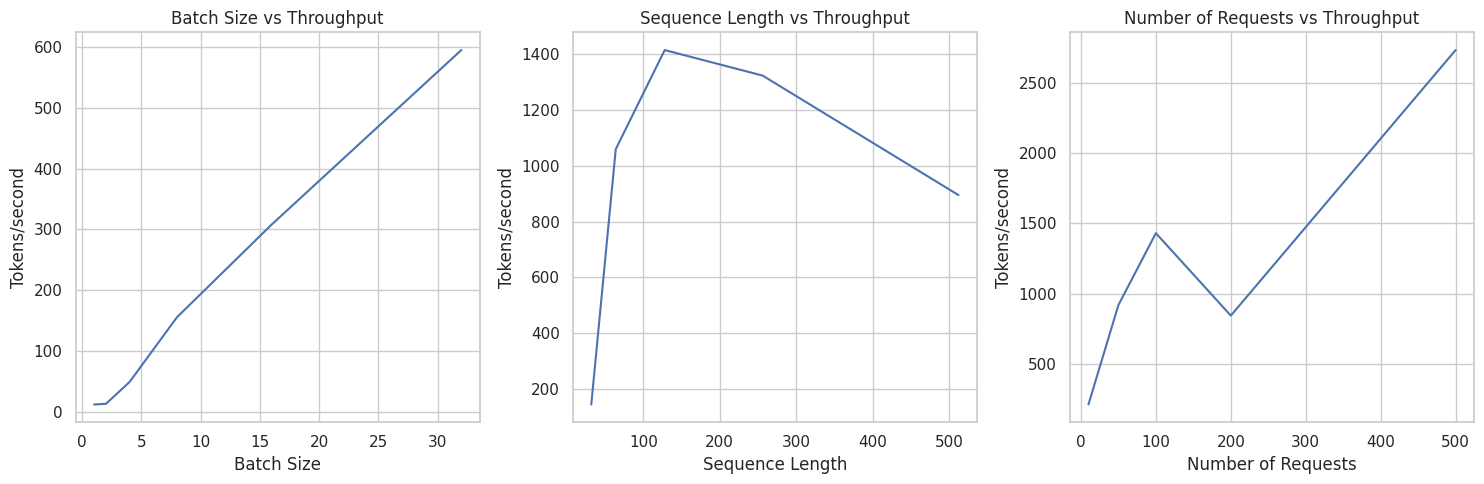

In [ ]:
def run_all_experiments(model_name: str = "facebook/opt-125m"):
    """Run all experiments and create visualizations."""

    # Experiment configurations
    batch_sizes = [1, 2, 4, 8, 16, 32]
    sequence_lengths = [32, 64, 128, 256, 512]
    request_counts = [10, 50, 100, 200, 500]

    # Run experiments
    print("Running batch size experiments...")
    batch_results = experiment_batch_sizes(model_name, batch_sizes)

    print("Running sequence length experiments...")
    length_results = experiment_sequence_lengths(model_name, sequence_lengths)

    print("Running request count experiments...")
    request_results = experiment_num_requests(model_name, request_counts)

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Batch size vs throughput
    plt.subplot(1, 3, 1)
    sns.lineplot(data=batch_results, x='batch_size', y='throughput')
    plt.title('Batch Size vs Throughput')
    plt.xlabel('Batch Size')
    plt.ylabel('Tokens/second')

    # Sequence length vs throughput
    plt.subplot(1, 3, 2)
    sns.lineplot(data=length_results, x='sequence_length', y='throughput')
    plt.title('Sequence Length vs Throughput')
    plt.xlabel('Sequence Length')
    plt.ylabel('Tokens/second')

    # Number of requests vs throughput
    plt.subplot(1, 3, 3)
    sns.lineplot(data=request_results, x='num_requests', y='throughput')
    plt.title('Number of Requests vs Throughput')
    plt.xlabel('Number of Requests')
    plt.ylabel('Tokens/second')

    plt.tight_layout()
    plt.show()

    return batch_results, length_results, request_results

# Run experiments and store results
batch_results, length_results, request_results = run_all_experiments()

  - Analysis of the results


* **Batch size scaling:** Throughput rose almost linearly from batch = 1 → 32 (≈12 → ≈595 tok/s), indicating the T4 was underutilized at small batches and benefited from better GPU occupancy as the scheduler formed larger micro-batches. *Diminishing returns are visible by ≈16–32, suggesting you’re nearing either memory-bandwidth or scheduler limits for this model/setting.*

* **Sequence length “sweet spot”:** Generated-throughput increased from 32 → 128 tokens (≈146 → ≈1413 tok/s), then declined at 256 and 512 (≈1322 and ≈895 tok/s). *Short sequences underutilize the GPU (overhead/prefill dominate), medium lengths amortize overhead and keep decode kernels busy, and very long sequences increase prefill cost and KV-cache pressure enough to reduce overall tokens/sec.*

* **Concurrency effects:** Scaling with more requests was non-monotonic: 10 → 100 requests improved (≈214 → ≈1431 tok/s), 200 dipped (≈846 tok/s), then 500 jumped sharply (≈2732 tok/s). *This pattern reflects the scheduler’s batching dynamics and memory pressure—at 200 you may have hit a suboptimal packing/fragmentation regime; at 500 there’s enough queue depth to fully saturate the device despite higher per-request latency.*

* **Prefill vs decode intuition:** *Longer inputs* hurt throughput because prefill cost grows and stalls decoding; *moderate outputs* help by sustaining efficient decode steps; *very long outputs* eventually hit memory/scheduling ceilings. Your curves mirror this: best tokens/sec at mid lengths, not extremes.

* **Most efficient tested regime:** The highest tokens/sec appeared with many concurrent requests and moderate sequence lengths (e.g., 500×[128→64] gave ≈2732 tok/s). *Great for throughput-oriented serving, but expect higher tail latency per request.*

* **Impact of engine knobs:** Using `max_num_batched_tokens=2048` for batch-size sweeps vs 4096 for other sweeps likely contributed to differences across charts. *For strict cross-experiment comparisons, keep this constant or report it prominently alongside results.*

* **Practical takeaway for serving:** If your goal is *maximum throughput*, increase batch/concurrency until you observe saturation or instability, and favor moderate prompt/generation lengths. If your goal is *lower latency*, reduce batch/concurrency and/or sequence lengths, accepting lower tokens/sec.

* **Stability considerations:** Results were single-run; *repeat trials and report mean±std* would smooth scheduler variance (especially around the 200-request dip). Warm-ups were used, which is good; *engine reuse across sweeps* could further reduce setup variance.

* **Resource guidance:** On a T4, OPT-125M scales well up to mid-range batch/concurrency before memory and prefill costs dominate. *If you move to a larger model or longer contexts, expect earlier saturation and sharper drops without adjusting batching limits and KV-cache settings.*


### Quick rundown of methods and settings used.




**LLM Inference Benchmarking — Methods & Settings**

**Hardware & Runtime**
- Device: NVIDIA T4 (Colab)
- Frameworks: PyTorch + vLLM
- Precision: `dtype="auto"` (fp16 on CUDA)
- Tensor parallelism: `tensor_parallel_size = 1`
- GPU memory target: `gpu_memory_utilization = 0.9`
- vLLM scheduler: `max_num_batched_tokens = 2048` (batch-size sweep), `4096` (length & requests sweeps)
- Warm-up: 1 untimed request prior to each measured run
- Engine lifecycle: new vLLM `LLM` instance per experiment point (measures generation only; load time excluded)

**Model & Tokenization**
- Model: `facebook/opt-125m`
- Tokenizer: matching HF tokenizer
- Special tokens: EOS kept default; synthetic prompts built to exact token counts

**Sampling / Decoding**
- Strategy: greedy (deterministic)
- Parameters: `temperature = 0.0`, `n = 1` (sequences per prompt)
- Stopping: `max_new_tokens` set per experiment; no custom stop sequences

**Metric Definitions**
- Primary throughput: *generated tokens per second* = `(#requests × output_len × n) / elapsed_seconds`
- Secondary (reported in logs): approx *input+output tokens per second*
- Timing window: generation phase only (between `t0` and `t1` after warm-up)

**Fixed Controls Across Sweeps**
- Unless noted, `tensor_parallel_size = 1`, `gpu_memory_utilization = 0.9`, `n = 1`, greedy decoding

**Sweep Configurations**
- *Batch-size sweep*  
  - Fixed lengths: input = **128** tokens, output = **64** tokens  
  - Batch sizes tested: **[1, 2, 4, 8, 16, 32]**  
  - Scheduler cap: `max_num_batched_tokens = 2048`

- *Sequence-length sweep*  
  - Fixed #requests: **64**  
  - Paired lengths tested (input = output): **[32, 64, 128, 256, 512]**  
  - Scheduler cap: `max_num_batched_tokens = 4096`

- *Request-count sweep*  
  - Fixed lengths: input = **128** tokens, output = **64** tokens  
  - Request counts tested: **[10, 50, 100, 200, 500]**  
  - Scheduler cap: `max_num_batched_tokens = 4096`

**Reproducibility / Variance**
- Runs per point: **1** (single measurement)  
- Notes: warm-up used; scheduler/batching can introduce variance at certain sizes. For higher rigor, repeat each point 3× and report mean ± std.

**Notes / Caveats**
- Very long inputs increase prefill cost and KV-cache usage; very high concurrency may trigger scheduling/memory effects.  
- Cross-figure comparisons should consider that `max_num_batched_tokens` differs between sweeps (2048 vs 4096).
